# Source: https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/

In [1]:
def load_data(debug=False, edgeDetect=False, folder='Fill2NoBg'):
    from keras.utils import to_categorical
    
    # loading data
    PATH = os.getcwd()
    # Define data path
    data_path = PATH + '/../ShapeData/' + folder
    data_dir_list = os.listdir(data_path)
    data_dir_list = [data_dir_list[2]] #0=Ellipse 1=Quadrilateral 2=Triangle
    img_data_list = []


    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)
        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            if edgeDetect:
                input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img,1)
                img_data_list.append(edge_detection(input_img))
            else:
                input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img,0)#1=RGB,0=Grey,-1=unchanged
                img_data_list.append(input_img)
#            input_img_resize=cv2.resize(input_img,(IMAGE_HEIGHT,IMAGE_WIDTH))
#            img_data_list.append(input_img_resize)
#             img_data_list.append(edge_detection(input_img))
    
    X_train = np.array(img_data_list)
    
    #Reshaping
    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], num_channels))
    
    if debug:
        print('After preprocessing: ')
        print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
        print(' - X_val.shape = {}, y_val.shape = {}'.format(X_val.shape, y_val.shape))
        print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))
        print(' - test_images.shape = {}, test_labels.shape = {}'.format(
            test_images.shape, test_labels.shape))  
    
    return X_train

In [2]:
import numpy as np
import os,cv2
X = load_data()
X = X.astype('float32') / 255.0 - 0.5

Using TensorFlow backend.


Loaded the images of dataset-Triangle



In [3]:
import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1),cmap='gray')
show_image(X[6])

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [5]:
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [6]:
IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 100)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 40, 40)]          0         
_________________________________________________________________
sequential (Sequential)      (None, 100)               160100    
_________________________________________________________________
sequential_1 (Sequential)    (None, 40, 40)            161600    
Total params: 321,700
Trainable params: 321,700
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=5,
                validation_data=[X_test, X_test])

Train on 18000 samples, validate on 2000 samples
Epoch 1/5
18000/18000 [==============================] - 2s 123us/sample - loss: 0.0171 - val_loss: 0.0108
Epoch 2/5
18000/18000 [==============================] - 1s 79us/sample - loss: 0.0091 - val_loss: 0.0083
Epoch 3/5
18000/18000 [==============================] - 2s 84us/sample - loss: 0.0074 - val_loss: 0.0070
Epoch 4/5
18000/18000 [==============================] - 1s 77us/sample - loss: 0.0064 - val_loss: 0.0063
Epoch 5/5
18000/18000 [==============================] - 1s 80us/sample - loss: 0.0058 - val_loss: 0.0058


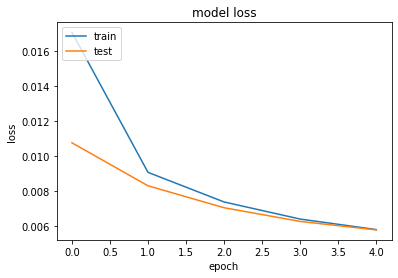

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

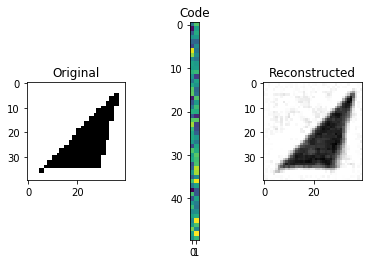

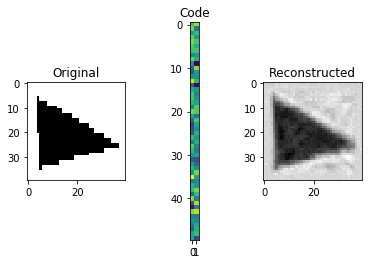

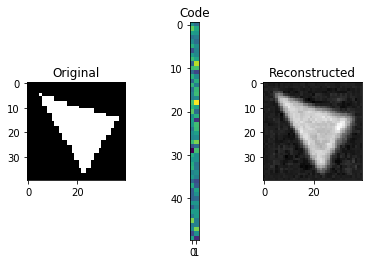

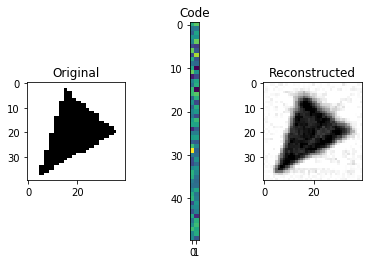

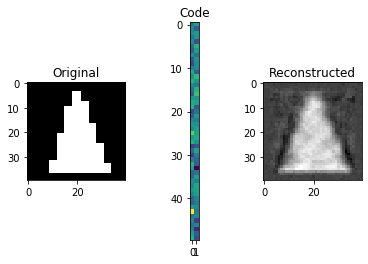

In [9]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()
    
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [14]:
encoder.save('encoder.h5')
decoder.save('decoder.h5')

In [11]:
def apply_gaussian_noise(X, sigma=0.1):
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    return X + noise

In [12]:
code_size = 100

# We can use bigger code size for better quality
encoder, decoder = build_autoencoder(IMG_SHAPE, code_size=code_size)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(25):
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)

    # We continue to train our model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=[X_test_noise, X_test])

Epoch 1/25, Generating corrupted samples...
Train on 18000 samples, validate on 2000 samples
18000/18000 [==============================] - 2s 117us/sample - loss: 0.0192 - val_loss: 0.0125
Epoch 2/25, Generating corrupted samples...
Train on 18000 samples, validate on 2000 samples
18000/18000 [==============================] - 2s 84us/sample - loss: 0.0104 - val_loss: 0.0094
Epoch 3/25, Generating corrupted samples...
Train on 18000 samples, validate on 2000 samples
18000/18000 [==============================] - 2s 86us/sample - loss: 0.0083 - val_loss: 0.0078
Epoch 4/25, Generating corrupted samples...
Train on 18000 samples, validate on 2000 samples
18000/18000 [==============================] - 1s 82us/sample - loss: 0.0072 - val_loss: 0.0069
Epoch 5/25, Generating corrupted samples...
Train on 18000 samples, validate on 2000 samples
18000/18000 [==============================] - 1s 81us/sample - loss: 0.0065 - val_loss: 0.0064
Epoch 6/25, Generating corrupted samples...
Train on 1

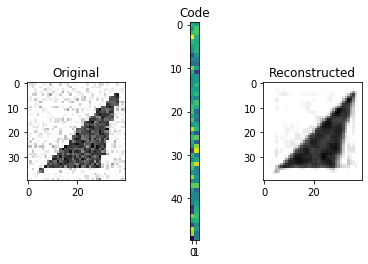

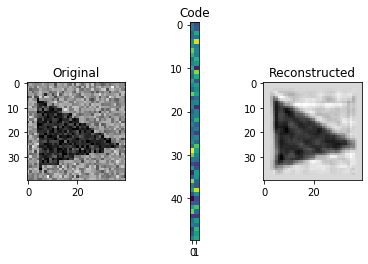

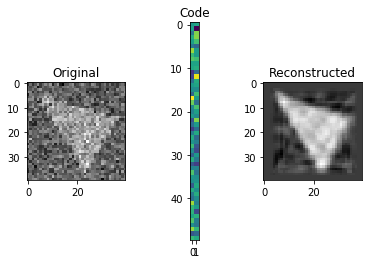

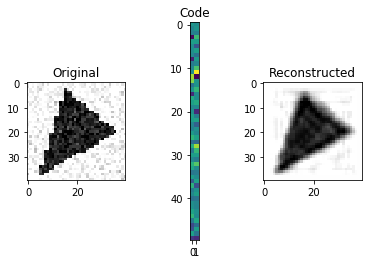

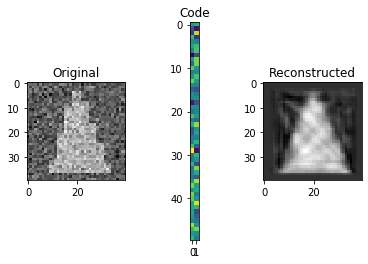

In [13]:
X_test_noise = apply_gaussian_noise(X_test)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)